Based on [https://docs.opencv.org/3.3.1/dd/d12/tutorial_omnidir_calib_main.html](https://docs.opencv.org/3.3.1/dd/d12/tutorial_omnidir_calib_main.html)

API documentation: [cv2.omnidir.undistortImage()](https://docs.opencv.org/3.4.2/d3/ddc/group__ccalib.html#gafe4f53d9b64bfe15b86e75a4699cbba4)

Source code: [omnidir.cpp](https://github.com/opencv/opencv_contrib/blob/master/modules/ccalib/src/omnidir.cpp)

In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import yaml

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15, 15]

In [3]:
def plot(img):
    new_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(new_img);

In [4]:
def read_ucm_params_kalibr(filename, cam='cam0'):
    with open(filename, 'r') as stream:
        try:
            data = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    dp = data[cam]['distortion_coeffs']
    D = np.array(dp)
    pp = data[cam]['intrinsics']
    K = np.eye(3)
    K[0][0] = pp[1]
    K[1][1] = pp[2]
    K[0][2] = pp[3]
    K[1][2] = pp[4]
    xi = np.array(pp[:1])
    return xi, K, D

In [5]:
def initRectifyMap(K, D, xi):
    flags = cv2.omnidir.RECTIFY_LONGLATI
    new_size = (640, 640)
    Knew = np.eye(3)
    nh = new_size[0]
    nw = new_size[1]
    Knew[0][0] = nw / np.pi
    Knew[1][1] = nh / np.pi
    R = np.eye(3)
    map1, map2 = cv2.omnidir.initUndistortRectifyMap(K, D, xi, R, Knew, new_size, cv2.CV_16SC2, flags)
    return map1, map2

In [6]:
def equirectangular_projection(img, map1, map2):
    undistorted_img = cv2.remap(img, map1, map2, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
    return undistorted_img

In [14]:
def rotate_cw_90(img):
    img_t = cv2.transpose(img)
    img_f = cv2.flip(img_t, flipCode=1)
    return img_f

In [15]:
def rotate_ccw_90(img):
    img_t = cv2.transpose(img)
    img_f = cv2.flip(img_t, flipCode=0)
    return img_f

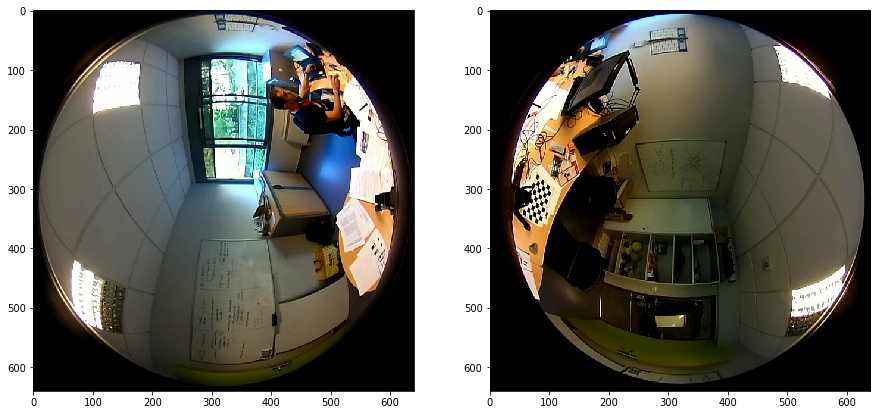

In [16]:
front_img = cv2.imread('front.png')
plt.subplot(121); plot(front_img);
back_img = cv2.imread('back.png')
plt.subplot(122); plot(back_img);

In [10]:
params_file = '../../config/camchain-2019-06-20-14-29-45.yaml'
xi_f, K_f, D_f = read_ucm_params_kalibr(params_file, 'cam3')
xi_b, K_b, D_b = read_ucm_params_kalibr(params_file, 'cam2')

In [11]:
%%time
map1_f, map2_f = initRectifyMap(K_f, D_f, xi_f)
map1_b, map2_b = initRectifyMap(K_b, D_b, xi_b)

CPU times: user 155 ms, sys: 0 ns, total: 155 ms
Wall time: 161 ms


In [19]:
%%time
front_eqimg = equirectangular_projection(front_img, map1_f, map2_f)
back_eqimg = equirectangular_projection(back_img, map1_b, map2_b)
both_eqimg = np.concatenate((rotate_cw_90(front_eqimg), rotate_ccw_90(back_eqimg)), axis=1)
panorama = np.roll(both_eqimg, 320, axis=1)

CPU times: user 12.1 ms, sys: 4.04 ms, total: 16.1 ms
Wall time: 6.34 ms


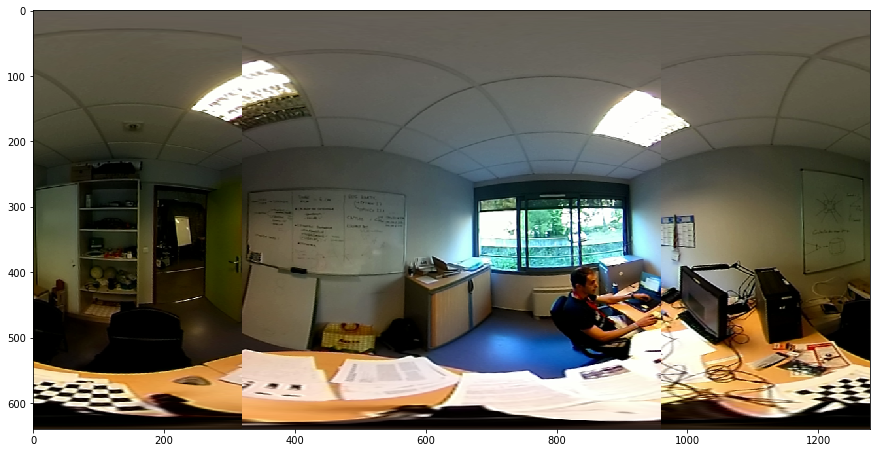

In [20]:
plot(panorama);

In [19]:
cv2.imwrite('panorama.png',panorama)

True

In [71]:
def initRectifyMap(K, D, xi):
    flags = cv2.omnidir.RECTIFY_LONGLATI
    new_size = (640, 640)
    Knew = np.eye(3)
    nh = new_size[0]
    nw = new_size[1]
    Knew[0][0] = nw / (1*np.pi)
    Knew[1][1] = nh / (1*np.pi)
    R = np.eye(3)
    map1, map2 = cv2.omnidir.initUndistortRectifyMap(K, D, xi, R, Knew, new_size, cv2.CV_32FC1, flags)
    return map1, map2

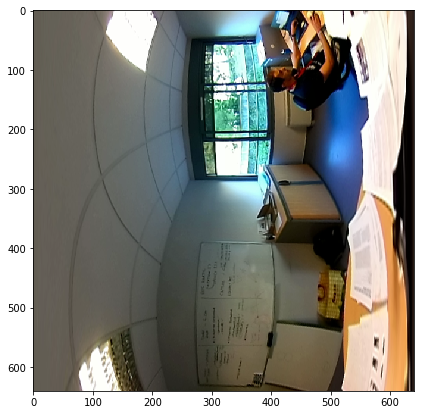

In [72]:
map1_f, map2_f = initRectifyMap(K_f, D_f, xi_f)
front_eqimg = equirectangular_projection(front_img, map1_f, map2_f)
plot(front_eqimg)

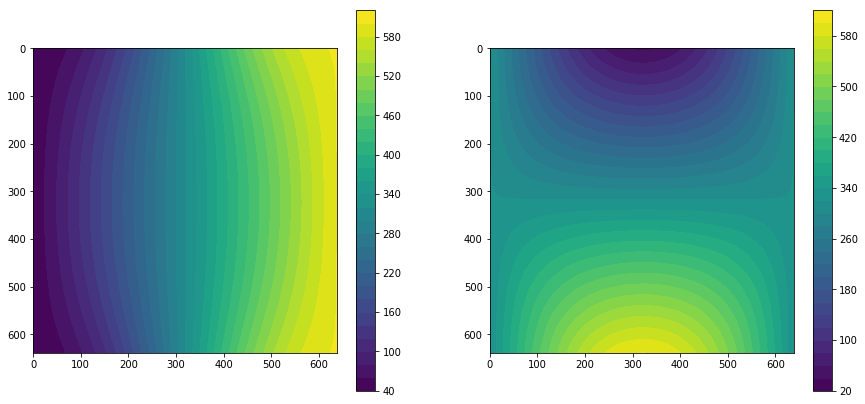

In [75]:
matplotlib.rcParams['figure.figsize'] = [15, 7]
plt.subplot(121); plt.contourf(map1_f, 32); plt.gca().invert_yaxis(); plt.axis('scaled'); plt.colorbar();
plt.subplot(122); plt.contourf(map2_f, 32); plt.gca().invert_yaxis(); plt.axis('scaled'); plt.colorbar();

### Compute map for spherical projection

In [133]:
def toSphereRad(theta, phi):
    out = np.zeros(3, dtype=float)
    out[0] = np.sin(theta) * np.cos(phi)
    out[1] = np.sin(phi)
    out[2] = np.cos(theta) * np.cos(phi)
    return out

In [134]:
def create_spherical_proj(K, xi, D, plus_theta, zi, rho_limit):
    rvec = np.zeros(3)
    tvec = np.zeros(3)
    mapx = np.zeros((640, 1280), dtype=np.float32)
    mapy = np.zeros((640, 1280), dtype=np.float32)
    height, width = mapx.shape
    step_theta = 2*np.pi / width
    step_phi = np.pi / height
    for i in range(height):
        for j in range(width):
            theta = j * step_theta - np.pi + plus_theta
            phi = i * step_phi - np.pi/2
            d = toSphereRad(theta, phi)
            rho = np.arccos(d[2])
            d[2] += zi
            if rho < rho_limit:
                imagePoints, _ = cv2.omnidir.projectPoints(np.array([[d]]), rvec, tvec, K, xi, D)
                m = imagePoints[0][0]
                mapx[i][j] = m[0]
                mapy[i][j] = m[1]
            else:
                mapx[i][j] = -1
                mapy[i][j] = -1
    return mapx, mapy

In [139]:
def toSphereRad(theta, phi):
    out = np.zeros((3, 1280),dtype=float)
    out[0,:] = np.sin(theta) * np.cos(phi)
    out[1,:] = np.sin(phi)
    out[2,:] = np.cos(theta) * np.cos(phi)
    return out

In [188]:
def create_spherical_proj(K, xi, D, plus_theta, zi, rho_limit):
    rvec = np.zeros(3)
    tvec = np.zeros(3)
    mapx = np.zeros((640, 1280), dtype=np.float32)
    mapy = np.zeros((640, 1280), dtype=np.float32)
    height, width = mapx.shape
    step_theta = 2*np.pi / width
    step_phi = np.pi / height
    for i in range(height):
        j = np.array(range(width))
        theta = j * step_theta - np.pi + plus_theta
        phi = i * step_phi - np.pi/2
        d = toSphereRad(theta, phi)
        rho = np.arccos(d[2,:])
        d[2,:] += zi
        imagePoints, _ = cv2.omnidir.projectPoints(np.reshape(np.transpose(d), (1,1280,3)), rvec, tvec, K, xi, D)
        ip = np.transpose(np.reshape(imagePoints, (1280, 2)))
        ip[:,rho>rho_limit] = -1
        mapx[i,:] = ip[0,:]
        mapy[i,:] = ip[1,:]
    return mapx, mapy

CPU times: user 577 ms, sys: 0 ns, total: 577 ms
Wall time: 553 ms


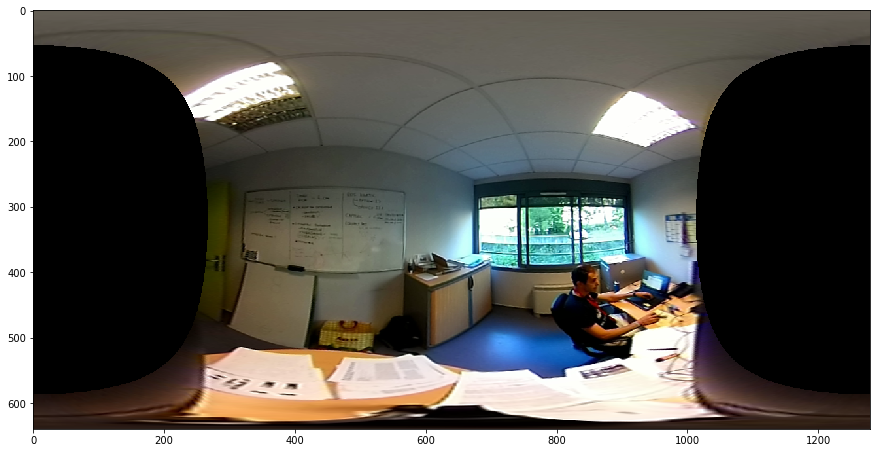

In [195]:
%%time
map1_f, map2_f = create_spherical_proj(K_f, xi_f, D_f, 0, 0, np.pi/2 * 105.0/90)
front_eqimg = equirectangular_projection(rotate_cw_90(front_img), map1_f, map2_f)
plot(front_eqimg)

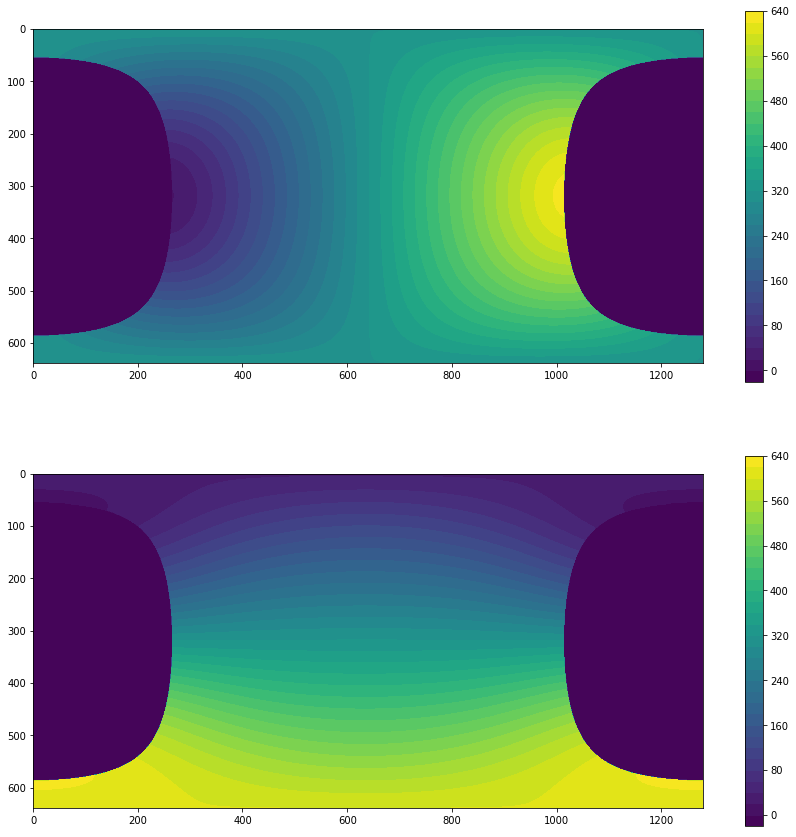

In [196]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
plt.subplot(211); plt.contourf(map1_f, 32); plt.gca().invert_yaxis(); plt.axis('scaled'); plt.colorbar();
plt.subplot(212); plt.contourf(map2_f, 32); plt.gca().invert_yaxis(); plt.axis('scaled'); plt.colorbar();

In [23]:
def simpleBlend(front, back):
    front_gray = cv2.cvtColor(front, cv2.COLOR_BGR2GRAY)
    back_gray  = cv2.cvtColor(back,  cv2.COLOR_BGR2GRAY)
    f_mask = front_gray>0
    b_mask = back_gray>0
    intersect = np.array(f_mask * b_mask, dtype=np.uint8)
    s = front + back
    hs = front/2 + back/2
    r2 = cv2.bitwise_and(hs, hs, mask = intersect)
    r1 = cv2.bitwise_and(s, s, mask = 1-intersect)
    result = r1 + r2
    return result

In [110]:
%%time
map1_f, map2_f = create_spherical_proj(K_f, xi_f, D_f, 0, 0, np.pi/2 * 91.25/90)

CPU times: user 29.1 s, sys: 0 ns, total: 29.1 s
Wall time: 29.1 s


In [111]:
%%time
map1_b, map2_b = create_spherical_proj(K_b, xi_b, D_b, np.pi, 0.0025, np.pi/2 * 91.25/90)

CPU times: user 28.4 s, sys: 9.04 ms, total: 28.5 s
Wall time: 28.4 s


In [112]:
%%time
front_eqimg = cv2.remap(rotate_cw_90(front_img), map1_f, map2_f, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
back_eqimg  = cv2.remap(rotate_ccw_90(back_img),  map1_b, map2_b, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
panorama_blend = simpleBlend(front_eqimg, back_eqimg)

CPU times: user 119 ms, sys: 446 µs, total: 119 ms
Wall time: 56.2 ms


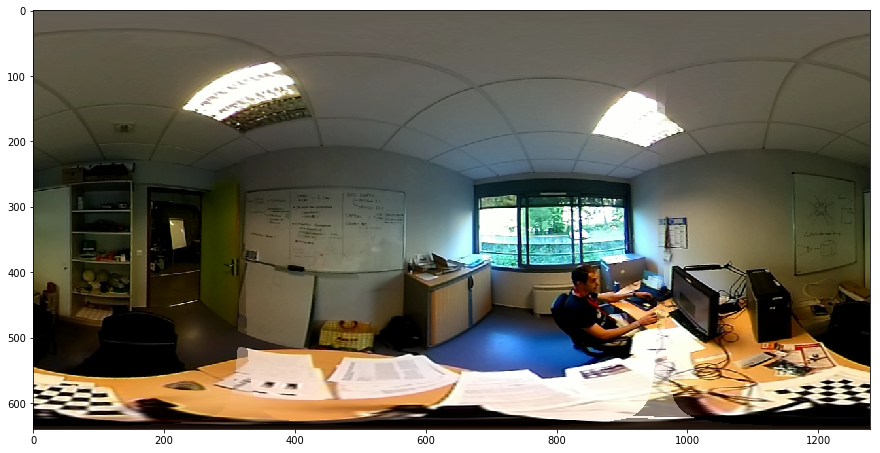

In [113]:
plot(panorama_blend);

In [114]:
cv2.imwrite('panorama_blend.png',panorama_blend)

True

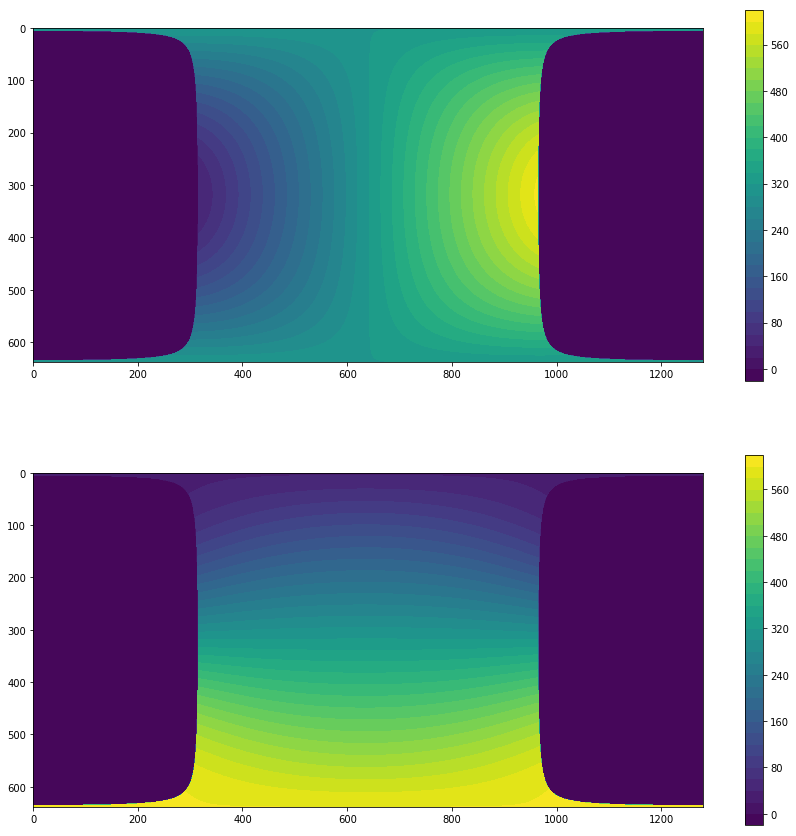

In [115]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
plt.subplot(211); plt.contourf(map1_f, 32); plt.gca().invert_yaxis(); plt.axis('scaled'); plt.colorbar();
plt.subplot(212); plt.contourf(map2_f, 32); plt.gca().invert_yaxis(); plt.axis('scaled'); plt.colorbar();